In [3]:
# Import dependencies
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf
import import_ipynb

# Custom user defined imports
from camera_feed import live_feed

### Preliminary Data Investigation

In [4]:
# Import test dataset
path = r'Data\train.csv'
df = pd.read_csv(path)

In [5]:
# Function to convert pixel strings to numpy array
def string_to_array(string):
    """ Convert space-separated pixel values to numpy array """
    return np.array(string.split(), dtype='float32').reshape(48, 48)

# apply conversions
df['image'] = df['pixels'].apply(string_to_array)

# Get unique emotion classes
emotion_classes = np.sort(df['emotion'].unique())

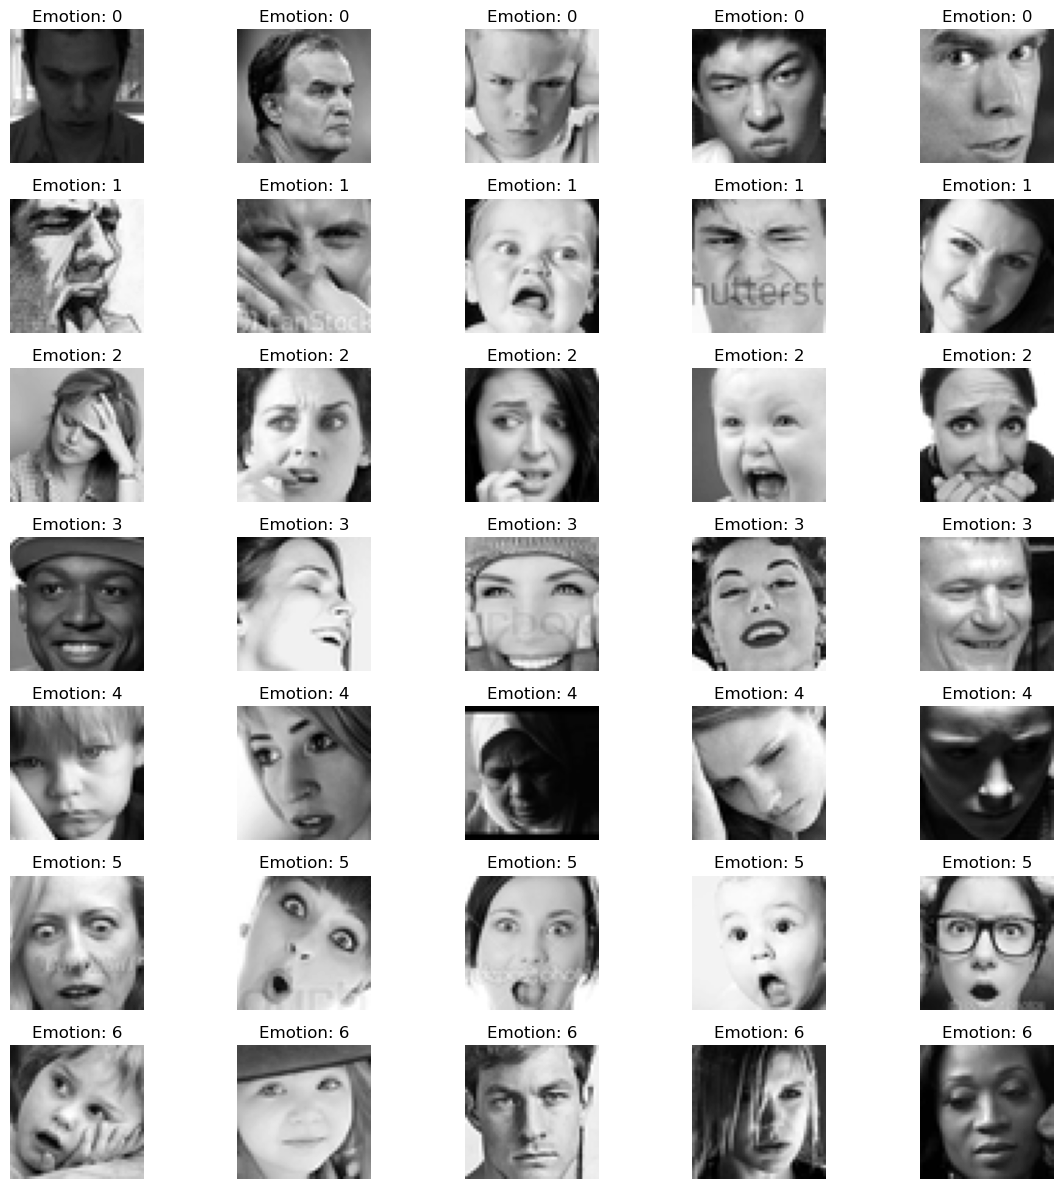

In [6]:
# Plot five images per emotion class
num_images_per_class = 5
fig, axes = plt.subplots(len(emotion_classes), 
                         num_images_per_class, 
                         figsize=(12, 12))

# Specify seed for consistent results
np.random.seed(10)

# Iterate through each emotion class and plot images
for i, emotion_class in enumerate(emotion_classes):
    
    # Select 5 random images from current emotion class
    images = df[df['emotion'] == emotion_class].sample(num_images_per_class)['image'].values
    
    for j in range(num_images_per_class):
        axes[i, j].imshow(images[j], cmap='gray')
        axes[i, j].set_title(f'Emotion: {emotion_class}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

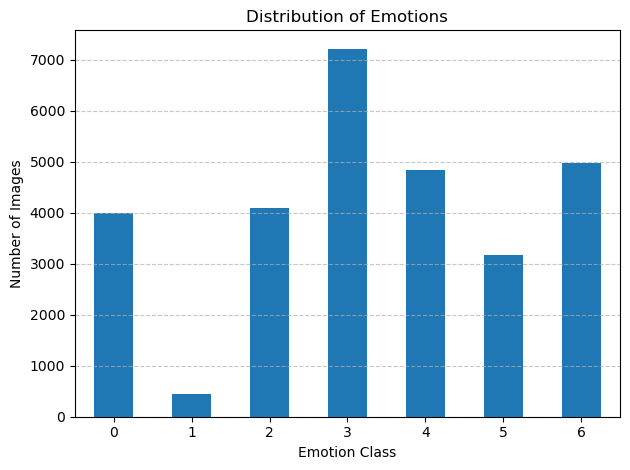

In [7]:
# Plotting the histogram of emotion distribution
plt.figure()
df['emotion'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Emotions')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Notes:
Take note that we have 7 total classes:
- 0=Angry,
- 1=Disgust, 
- 2=Fear, 
- 3=Happy, 
- 4=Sad, 
- 5=Surprise, 
- 6=Neutral

Each image is 48X48 pixel greyscale images of faces. The faces are more/less centered and occupies the same amount of space in each image. The bar graph shows that class 1 has the lowest representation in the training dataset.

Source: https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/data

### Model Creation

## Note !
since I am using the training dataset csv, I will not be creating the testing dataset (that is given in another csv); I am sticking with the original challenge instructions. We can have this changed though. 

In [8]:
# Normalize the values in the image column
df['image'] /= 255.0

# Specify training datasets
X_train = df['image'].to_numpy()
y_train = df['emotion'].to_numpy()

# Reshape the data to (48, 48, 1)
X_train= [i.reshape(48, 48, 1) for i in X_train]

# Esnure numpy array
X_train = np.array(X_train)

# Print shapes
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (28709, 48, 48, 1)
y_train shape: (28709,)


In [9]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='metric'):

    # Build NN model
    model = tf.keras.Sequential()
    
    # Add input layer
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28))) 
    
    # Add hidden layers
    for units in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units, activation=activation))
        
    # Add output layer
    model.add(tf.keras.layers.Dense(n_classes, activation = 'softmax'))
    
    # Select optimizer based on user input
    if optimizer == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    else:
        raise ValueError('Please enter the correct optimizer (SGD or Adam)')
    
    # Compile model
    model.compile(optimizer = opt,
                 loss = 'sparse_categorical_crossentropy',
                 metrics = [metric]
                 )

    return model

In [10]:
# Create function to define CNN model with default parameters
def create_CNN(n_classes = 10,
               neurons = 128,
               dropout_rate = 0.5,
               num_filters = [32,64,128],
               filter_sizes = [(3,3),(3,3),(3,3)],
               maxpools=[(2, 2), (2, 2), (2, 2)],
               activation = 'relu',
               optimizer = 'adam',
               learning_rate = 0.001,
               metric = ['accuracy'],
               conv_layers = 3,):
    """
    Create a Convolutional Neural Network (CNN) model for image classification (48x48x1).

    Parameters:
    -----------
    n_classes : int
        Number of classes in the classification task.

    neurons : int
        Number of neurons in the fully connected dense layer.

    dropout_rate : float
        Dropout rate to prevent overfitting.

    num_filters : list of int
        List of integers specifying the number of filters for each Conv2D layer.

    filter_sizes : list of tuples
        List of tuples specifying the size of filters (height, width) for each Conv2D layer.

    maxpools : list of tuples
        List of tuples specifying the size of max pooling windows (height, width) for each MaxPooling2D layer.

    activation : str
        Activation function to use in Conv2D and Dense layers.

    optimizer : str or tf.keras.optimizers.Optimizer
        Optimizer to use for training the model.

    learning_rate : float
        Learning rate for the optimizer.

    metrics : list of str
        List of metrics to evaluate during training and testing.

    conv_layers : int
        Number of convolutional layers to include in the CNN architecture.

    Returns:
    --------
    model : tf.keras.models.Sequential
        Compiled CNN model ready for training.
    """
    
    '''Clear session and set seed'''
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Validate input parameters
    if len(num_filters) != conv_layers or len(filter_sizes) != conv_layers or len(maxpools) != conv_layers:
        raise ValueError("Lengths of num_filters, filter_sizes, and maxpools must match conv_layers.")
    
    '''Build CNN based on user inputs'''
    model = Sequential()
    
    # Go through each layer input
    for i in range(conv_layers):
        # Conv2D Settings
        model.add(Conv2D(num_filters[i], 
                         filter_sizes[i], 
                         activation = activation,
                         input_shape = (48, 48, 1) if i == 0 else None)) # For initial layer only
        
        # MaxPooling settings
        model.add(MaxPooling2D(maxpools[i]))

    # Output layer
    model.add(tf.keras.layers.Flatten()) # Flatten
    model.add(Dense(neurons, activation=activation)) # Train on neurons
    model.add(Dropout(dropout_rate)) # Drop % to prevent overfitting
    model.add(Dense(n_classes, activation='softmax')) # Specify number of outputs

    '''Compile model'''
    model.compile(optimizer = optimizer,
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    
    # Print model summary
    print(model.summary)
    
    # Return statement
    return model

In [11]:
# Create model (Using default settings I've specified)
model = create_CNN()

# Train model for testing purposes
history = model.fit(X_train, y_train,
                   epochs = 20,
                   batch_size = 32,
                   validation_split = 0.4,
                   verbose = 0)



C:\Users\omar_\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<bound method Model.summary of <Sequential name=sequential, built=True>>


In [12]:
# Run live feed model for demonstration purposes
live_feed(model) # Type Q to exit out

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


### Next steps

1) create looping function to test combo of model parameters and fitting parameters and select min loss.
2) revist transforming the raw data during preprocessing phase
3) compile analysis of test results
4) further data investigation process (checkout CNN and NN hws). 